## Bottomline
It is unclear how this normalization is obtained from the non normalized files

 - The number of spectra in each coordinate is different (the normalized version has less values for every spectra)
 - The spectra at one random location still look very similar
 - No area can be identified to have int=1.0
 - The value m/z = 317.176 doesn't see to have an intensity of either 1.0 or 1.5 at any place
 - Centroiding doesn't help (but interesting note: the effect depends on the normalization ! The different algorithm produce very different results for the different normalizations)

Should ask Samuele about this...

In [1]:
import matplotlib.pyplot as plt
import pylab
import numpy as np
import pyopenms
import zarr

In [2]:
z_no_norm = zarr.open("../datasets/comulis13.zarr/", mode="r")
z_norm_2305 = zarr.open("../datasets/comulis13_norm_2305.zarr/", mode="r")

In [3]:
target = 317.176

In [4]:
def get_arrays(z: zarr.Group):
    z_int = z["/0"]
    z_mzs = z["/labels/mzs/0"]
    z_len = z["/labels/lengths/0"]
    
    return z_len, z_mzs, z_int 

def get_spectrum(z: zarr.Group, y: int, x: int):
    z_len, z_mzs, z_int = get_arrays(z)
    
    s_len = z_len[0, 0, y, x]
    s_mzs = z_mzs[:s_len, 0, y, x]
    s_int = z_int[:s_len, 0, y, x]
    
    return s_mzs, s_int

def get_valid_coordinates(z: zarr.Group):
    z_len, *_ = get_arrays(z)
    n_len = z_len[0, 0]
    return np.argwhere(n_len)

In [5]:
valid_coordinates = get_valid_coordinates(z_no_norm)
y, x = valid_coordinates[-3]

s_yx_no_norm = get_spectrum(z_no_norm, y, x)
s_yx_norm_2305 = get_spectrum(z_norm_2305, y, x)

## Compare the lengths

In [6]:
s_yx_no_norm[0].size, s_yx_norm_2305[0].size

(232392, 180608)

In [7]:
z_no_norm["/0"].shape, z_norm_2305["/0"].shape

((406594, 1, 644, 758), (406594, 1, 644, 758))

In [8]:
(z_no_norm["/labels/lengths/0"][0, 0] != z_norm_2305["/labels/lengths/0"][0, 0]).sum()

5426

In [9]:
np.count_nonzero(z_no_norm["/labels/lengths/0"][0, 0])

5427

In [69]:
diff = np.float32(z_no_norm["/labels/lengths/0"][0, 0] - z_norm_2305["/labels/lengths/0"][0, 0])
diff[z_no_norm["/labels/lengths/0"][0, 0] == 0] = np.nan

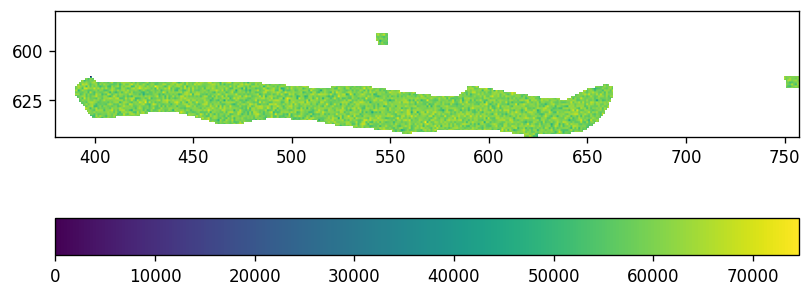

In [70]:
# oh shoot... why do they have different lengths ???
plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(diff)
plt.ylim(top=580)
plt.xlim(left=380)
plt.colorbar(location="bottom")

## Compare the spectra

In [12]:
# build spectra using pyopenms
spectrum_no_norm = pyopenms.MSSpectrum()
spectrum_no_norm.set_peaks(s_yx_no_norm)

spectrum_norm_2305 = pyopenms.MSSpectrum()
spectrum_norm_2305.set_peaks(s_yx_norm_2305)

spectrum_no_norm_picked = pyopenms.MSSpectrum()
spectrum_norm_2305_picked = pyopenms.MSSpectrum()

picker = pyopenms.PeakPickerHiRes()

picker.pick(spectrum_no_norm, spectrum_no_norm_picked)
picker.pick(spectrum_norm_2305, spectrum_norm_2305_picked)

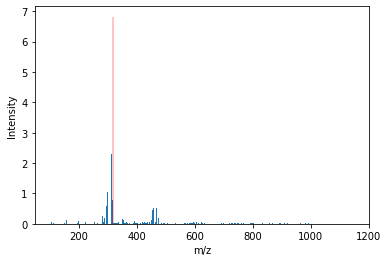

In [13]:
s_int = spectrum_norm_2305_picked.get_peaks()[1]
pylab.vlines(target, s_int.min(), s_int.max(), color="red", alpha=0.3)
pyopenms.Plotting.plotSpectrum(spectrum_norm_2305_picked)

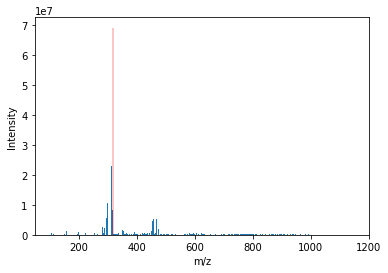

In [14]:
s_int = spectrum_no_norm_picked.get_peaks()[1]
pylab.vlines(target, s_int.min(), s_int.max(), color="red", alpha=0.3)
pyopenms.Plotting.plotSpectrum(spectrum_no_norm_picked)

In [15]:
spectrum_no_norm_picked.get_peaks()[0].size, spectrum_norm_2305_picked.get_peaks()[0].size

(13976, 12810)

## Is the area around m/z=317.176 normalized ? (No)

In [16]:
# focus on the area around the target (picked)
s_mzs, s_int = spectrum_norm_2305_picked.get_peaks()
lo, hi = s_mzs.searchsorted((target-10, target+10))
s_mzs, s_int = s_mzs[lo:hi], s_int[lo:hi]
spectrum_norm_2305_picked.set_peaks((s_mzs, s_int))


s_mzs, s_int = spectrum_no_norm_picked.get_peaks()
lo, hi = s_mzs.searchsorted((target-10, target+10))
s_mzs, s_int = s_mzs[lo:hi], s_int[lo:hi]
spectrum_no_norm_picked.set_peaks((s_mzs, s_int))

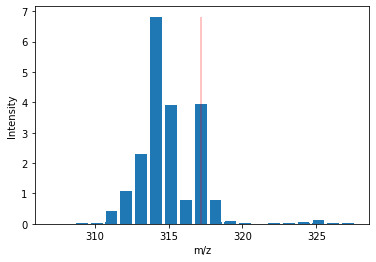

In [17]:
s_int = spectrum_norm_2305_picked.get_peaks()[1]
pylab.vlines(target, s_int.min(), s_int.max(), color="red", alpha=0.3)
pyopenms.Plotting.plotSpectrum(spectrum_norm_2305_picked)

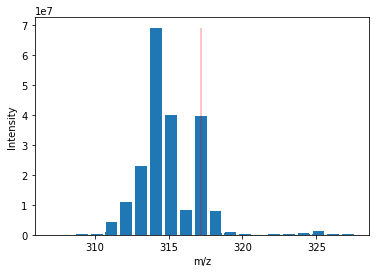

In [18]:
s_int = spectrum_no_norm_picked.get_peaks()[1]
pylab.vlines(target, s_int.min(), s_int.max(), color="red", alpha=0.3)
pyopenms.Plotting.plotSpectrum(spectrum_no_norm_picked)

In [19]:
# focus on the area around the target (picked)
s_mzs, s_int = spectrum_norm_2305.get_peaks()
lo, hi = s_mzs.searchsorted((target-10, target+10))
s_mzs, s_int = s_mzs[lo:hi], s_int[lo:hi]
spectrum_norm_2305.set_peaks((s_mzs, s_int))


s_mzs, s_int = spectrum_no_norm.get_peaks()
lo, hi = s_mzs.searchsorted((target-10, target+10))
s_mzs, s_int = s_mzs[lo:hi], s_int[lo:hi]
spectrum_no_norm.set_peaks((s_mzs, s_int))

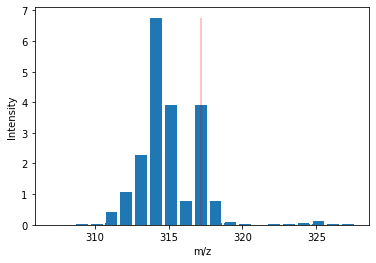

In [20]:
s_int = spectrum_norm_2305.get_peaks()[1]
pylab.vlines(target, s_int.min(), s_int.max(), color="red", alpha=0.3)
pyopenms.Plotting.plotSpectrum(spectrum_norm_2305)

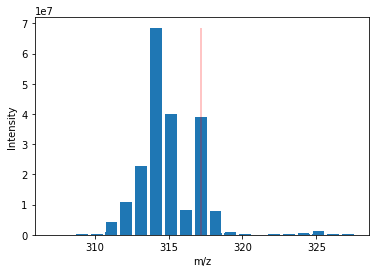

In [21]:
s_int = spectrum_no_norm.get_peaks()[1]
pylab.vlines(target, s_int.min(), s_int.max(), color="red", alpha=0.3)
pyopenms.Plotting.plotSpectrum(spectrum_no_norm)

## Is there any way to obtain the normalized spectrum from the raw one ? (Not that I could find)

In [22]:
s_yx_norm_2305[1].sum()

520.3152838908014

In [23]:
(s_yx_norm_2305[1]**2).sum()**(1/2)

22.059374577050725

In [24]:
s_yx_norm_2305[1].max()

6.755730413414653

In [28]:
s_yx_norm_2305[1].sum() / s_yx_norm_2305[1].max()

77.01836101358141

In [25]:
s_yx_no_norm[1].sum()

6795793511.278903

In [26]:
(s_yx_no_norm[1]**2).sum()**(1/2)

226418240.64871868

In [27]:
s_yx_no_norm[1].max()

68551664.0

In [29]:
s_yx_no_norm[1].sum() / s_yx_no_norm[1].max()

99.13389573269735

In [30]:
lo, hi = s_yx_norm_2305[0].searchsorted((target-0.5, target+0.5))
s_yx_norm_2305[0][lo:hi], s_yx_norm_2305[1][lo:hi]

(array([316.69445801, 316.69458008, 316.69470215, 316.69482422,
        316.69494629, 316.69506836, 316.69519043, 316.6953125 ,
        316.69543457, 316.69552612, 316.69564819, 316.74359131,
        316.74371338, 316.74380493, 316.743927  , 316.74404907,
        316.74417114, 316.74429321, 316.74441528, 316.74453735,
        316.74465942, 316.74478149, 316.76705933, 316.7671814 ,
        316.76730347, 316.76742554, 316.76754761, 316.76766968,
        316.82156372, 316.82168579, 316.82180786, 316.82192993,
        316.822052  , 316.82217407, 316.82229614, 316.82241821,
        316.82250977, 316.82263184, 316.82275391, 316.82287598,
        316.82299805, 316.82312012, 316.83935547, 316.83947754,
        316.83956909, 316.83969116, 316.83981323, 316.8399353 ,
        316.84005737, 316.84017944, 316.84030151, 316.84042358,
        316.89352417, 316.89364624, 316.89373779, 316.89385986,
        316.89398193, 316.894104  , 316.89422607, 316.89434814,
        316.89447021, 316.89459229, 316.

In [31]:
lo, hi = s_yx_no_norm[0].searchsorted((target-0.5, target+0.5))
s_yx_no_norm[0][lo:hi], s_yx_no_norm[1][lo:hi]

(array([316.69421387, 316.69433594, 316.69445801, 316.69458008,
        316.69470215, 316.69482422, 316.69494629, 316.69506836,
        316.69519043, 316.6953125 , 316.69543457, 316.69552612,
        316.69564819, 316.69577026, 316.7432251 , 316.74334717,
        316.74346924, 316.74359131, 316.74371338, 316.74380493,
        316.743927  , 316.74404907, 316.74417114, 316.74429321,
        316.74441528, 316.74453735, 316.74465942, 316.74478149,
        316.74490356, 316.74499512, 316.76693726, 316.76705933,
        316.7671814 , 316.76730347, 316.76742554, 316.76754761,
        316.76766968, 316.76779175, 316.82110596, 316.82119751,
        316.82131958, 316.82144165, 316.82156372, 316.82168579,
        316.82180786, 316.82192993, 316.822052  , 316.82217407,
        316.82229614, 316.82241821, 316.82250977, 316.82263184,
        316.82275391, 316.82287598, 316.82299805, 316.82312012,
        316.82324219, 316.83911133, 316.8392334 , 316.83935547,
        316.83947754, 316.83956909, 316.

## What does the distribution look like if we center around m/z=317.176 ? (not much)

In [32]:
z_no_norm["/0"].shape, z_norm_2305["/0"].shape

((406594, 1, 644, 758), (406594, 1, 644, 758))

In [33]:
from msi_zarr_analysis.utils.iter_chunks import iter_loaded_chunks

In [56]:
# see the whole image at target +/- tol ?
def search_plane(group: zarr.Group, mz_val: float = 317.176, mz_tol: float = 0.0005):
    z_len, z_mzs, z_int = get_arrays(group)
    n_len = z_len[0, 0]
    
    img = np.zeros(z_int.shape[-2:], z_int.dtype)
    
    for cy, cx in iter_loaded_chunks(z_int, skip=2):
        c_len = n_len[cy, cx]
        cap_len = c_len.max()
        c_int = z_int[:cap_len, 0, cy, cx]
        c_mzs = z_mzs[:cap_len, 0, cy, cx]
        
        for i in range(c_int.shape[1]):
            for j in range(c_int.shape[2]):
                s_len = c_len[i, j]
                s_mzs = c_mzs[:s_len, i, j]
                lo = s_mzs.searchsorted(mz_val-mz_tol, side='left')
                hi = s_mzs.searchsorted(mz_val+mz_tol, side='right')
                
                s_int = c_int[lo:hi, i, j]
                
                # sum all values ?
                # val = s_int.sum()
                
                # find the closest to 1.0 (could highlight close to 1 area)
                if s_int.size == 0:
                    val = np.nan
                else:
                    val = s_int[np.abs(s_int - 1).argmin()]
                
                img[
                    i+cy.start,
                    j+cx.start
                ] = val
    
    return img

In [57]:
img_no_norm = search_plane(z_no_norm)

In [58]:
img_norm_2305 = search_plane(z_norm_2305)

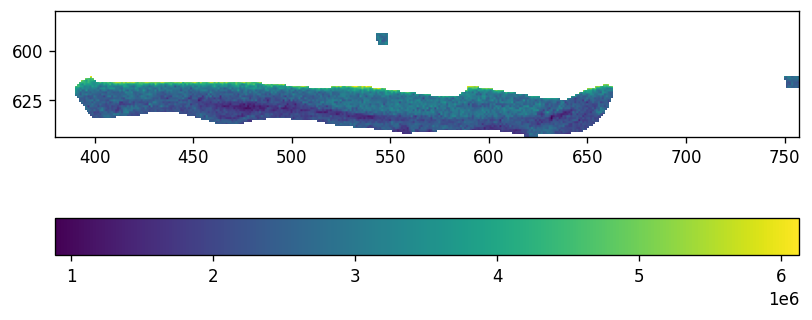

In [59]:
copy = img_no_norm.copy()
copy[copy==0] = np.nan
plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(copy)
plt.ylim(top=580)
plt.xlim(left=380)
plt.colorbar(location="bottom")

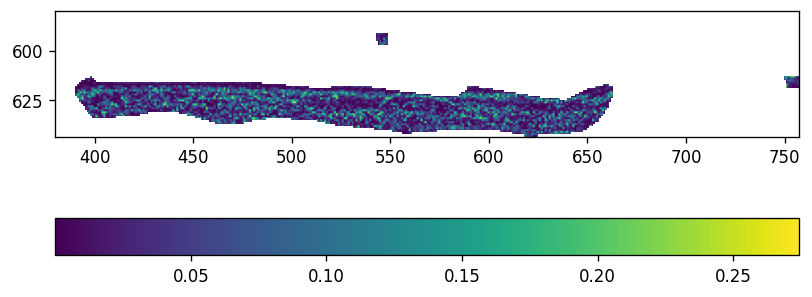

In [64]:
copy = img_norm_2305.copy()
copy[copy==0] = np.nan
plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(np.log(copy)**2)
plt.ylim(top=580)
plt.xlim(left=380)
plt.colorbar(location="bottom")